<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/main/code/basicGAN/basicGAN_20_steps_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

# home made
from utils.tools import *

In [4]:
def create_loop():

  a = np.random.uniform(low = 2, high = 5)

  A = np.random.uniform(low = 0.5, high = 1)

  t = np.arange(0, np.pi/a, 0.1)

  x = A * np.sin(a * t) * np.cos(t)
  y = A * np.sin(a * t) * np.sin(t)

  return x, y

In [5]:
### LOOPS

nb_traj = 100
padding = 20
traj = np.zeros((nb_traj, 2, padding))

for i in range(nb_traj):
    x,y = create_loop()

    traj[i,0,:len(x)] = x
    traj[i,1,:len(y)] = y

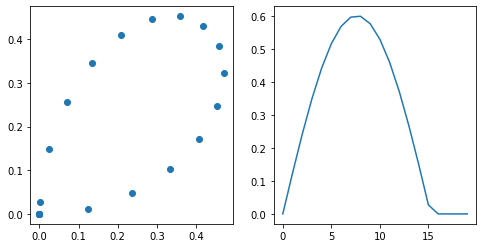

In [6]:
plt.figure(figsize = (8,4))

x = traj[0,0,:]
y = traj[0,1,:]

plt.subplot(1,2, 1)
plt.scatter(x, y)

plt.subplot(1,2, 2)
plt.plot(np.sqrt(x**2 + y**2))

In [7]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        
        self.traj = traj   # save trips
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        sample = traj[idx,:]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [8]:
# hyperparameters
batch_size = 20

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [9]:
x =  next(iter(train_loader))

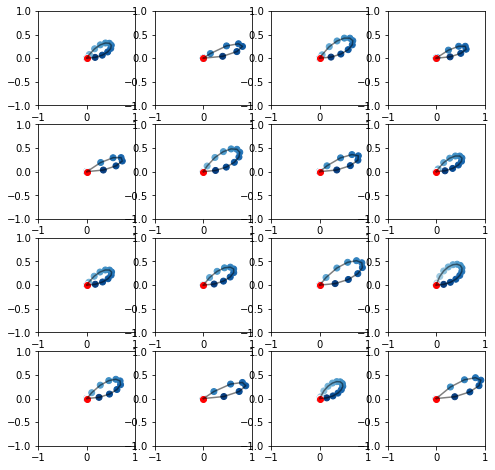

In [10]:
plt.figure(figsize = (8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [11]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## CNN

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(20, 10, kernel_size = 5, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(10),
            nn.ReLU(True),

            nn.ConvTranspose1d(10, 5, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(5),
            nn.ReLU(True),

            nn.ConvTranspose1d(5, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z, batch_size):    
        out = self.cnn(z)
        return out

In [14]:
gen = CNNGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([20, 2, 20])

In [15]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 5, kernel_size = 5, stride = 1, padding = 2, bias = False),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(5, 10, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(10, 20, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(20, 1, kernel_size=5, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, batch_size):

        out = self.cnn(x)

        return out.squeeze(1)


In [16]:
dis = CNNDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([20, 1])

In [17]:
sum(p.numel() for p in gen.parameters())

1270

# LSTM

In [18]:
class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 16, 1, batch_first=True, bias = True)
        self.linear = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state

        # init LSTM cells  (batch, seq, feature)
        out, h_n = self.lstm(x, (h_0, c_0))
        out = self.linear(out)
        out = out.view(batch_size, 2, padding)
        return torch.cumsum(out, 2)

In [19]:
gen = LSTMGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([20, 2, 20])

In [20]:
sum(p.numel() for p in gen.parameters())

1522

In [21]:
class LSTMDiscriminator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(2, 16, 1, batch_first=True)
        
        self.linear = nn.Sequential(
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 1),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #internal stat

        # init LSTM cells  (batch, seq, feature)
        out = x.view(batch_size, padding, 2)
        out, (h_n, c_n) = self.lstm(out, (h_0, c_0))
        out = self.linear(out)
        out = 1/(1 + torch.exp(-torch.mean(out, 1)))

        return out

In [22]:
dis = LSTMDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([20, 1])

In [23]:
class GAN :
  """
  This class creates a GAN with: 
   - a Generator network 
   - a Discriminator network
   - a Dataloader object from pytorch
  """
  def __init__(self, generator, discriminator, train_loader, device):
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)
    self.device = device
    self.train_loader = train_loader
    
  def train(self, nb_epoch, lr, device):
    """
    This function trains the GAN for nb_epoch with a fiwed learning rate lr
    """                                                       
    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr= lr, betas=(0.5, 0.999))
    optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))
    score = []

    time_start = time.perf_counter()
    for epoch in range(nb_epoch):
        i = 0

        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for _, x in enumerate(self.train_loader):

            batch = x.shape[0]
            
            target_ones = torch.ones((batch, 1), device=self.device)
            target_zeros = torch.zeros((batch, 1), device=self.device)
            
            i+= 1
            #### TRAIN DISCRIMINATOR
            ## true samples
            x = x.to(device)

            self.discriminator.zero_grad()
            pred_real = self.discriminator(x, batch)
            loss_real = criterion(pred_real, target_ones)

            ## false samples
            seq_length =  x.shape[2]
            z = torch.rand((batch, seq_length, 1), device=self.device)
            with torch.no_grad():
                fake_samples = self.generator(z, batch)
            pred_fake = self.discriminator(fake_samples, batch)
            loss_fake = criterion(pred_fake, target_zeros)
            
            # combine
            loss = (loss_real + loss_fake) / 2
            loss.backward()
            optim_d.step()

            loss_d_real_running += loss_real.item()
            loss_d_fake_running += loss_fake.item()
            
            #### TRAIN GENERATOR
            self.generator.zero_grad()
            z = torch.rand((batch, seq_length, 1), device=self.device) 

            generated = self.generator(z, batch)
            classifications = self.discriminator(generated, batch)
            loss = criterion(classifications, target_ones) #+ 0.1 * torch.sum((generated[:,0, 0] - generated[:,0,-1])**2)
            loss.backward()
            optim_g.step()

            loss_g_running += loss.item()

        if epoch%100 == 0:
          traj_sim = self.test(100)
          score.append(get_score(traj, traj_sim))
       
        if epoch%500 == 0:
          print('Epoch [{}/{}] -----------------------------------------------------------------------------'
              .format(epoch+1, nb_epoch, i, len(self.train_loader)))
          print('G: {}, Dr : {}, Df : {}'
              .format(loss_g_running/batch, loss_d_real_running/batch, loss_d_fake_running/batch))
          
          self.plot()


    #run your code
    self.score = score
    self.computation_time = (time.perf_counter() - time_start)

  def test(self, nb):
    """
    This function generates nb trajectories
    """ 
    self.generator.zero_grad()    

    x =  next(iter(self.train_loader))
    seq_length = x.shape[2]

    z = torch.rand((nb, seq_length, 1), device=self.device)
    generated = self.generator(z, nb)
    traj_sim = generated.cpu().detach().numpy()
    return traj_sim

  def plot(self):
    """
    This function plots few trajectories
    """ 
    traj_sim = self.test(16)

    plt.figure(figsize = (8,8))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
      plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
      plt.scatter(0,0, c = 'red')
      plt.xlim(-1,1)
      plt.ylim(-1,1)

    plt.show()
    plt.close()

  def save(self, name):
    torch.save(self.generator, name+'_G.pt')
    torch.save(self.discriminator, name+'_D.pt')

In [24]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# CNN - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.1813814550638199, Dr : 0.1487581342458725, Df : 0.16810389161109923


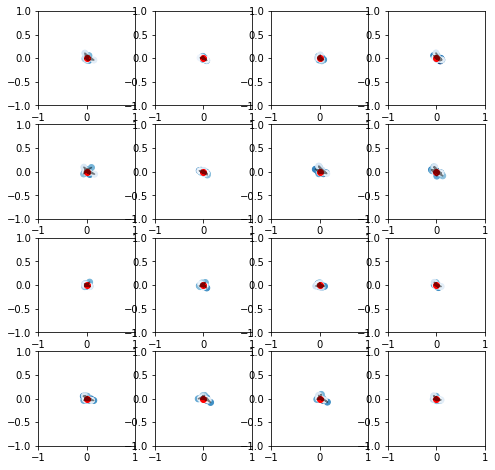

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.2775028020143509, Dr : 0.09716054201126098, Df : 0.10453796088695526


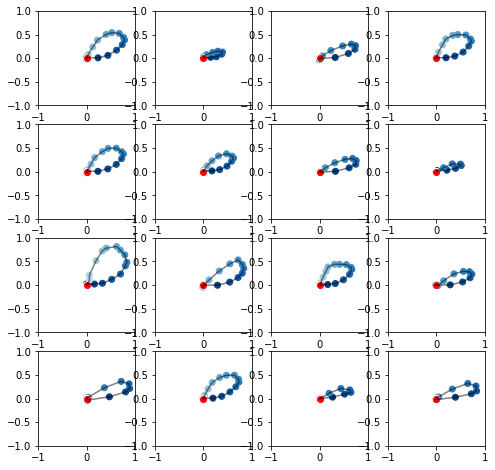

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.6861448764801026, Dr : 0.04051303640007973, Df : 0.03514342121779919


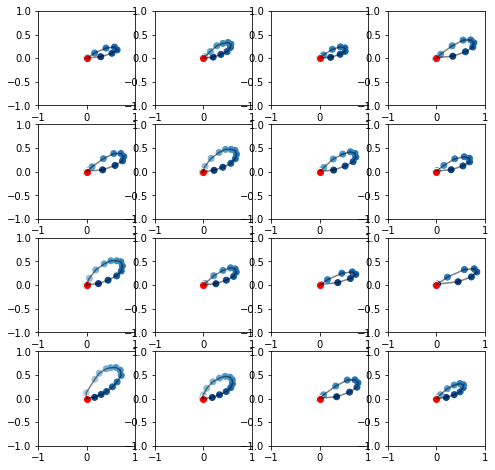

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.25014278292655945, Dr : 0.15542072849348187, Df : 0.13937781024724244


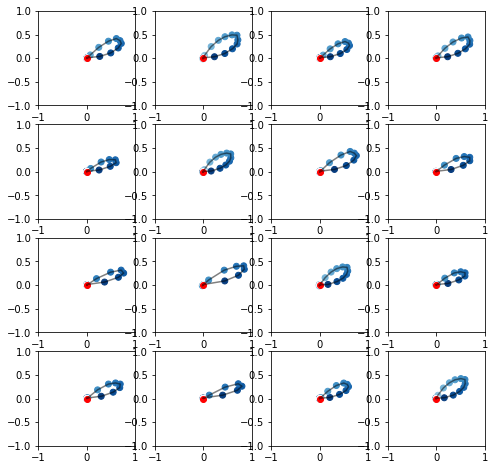

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 1.090913438796997, Dr : 0.009226292464882135, Df : 0.009321840154007078


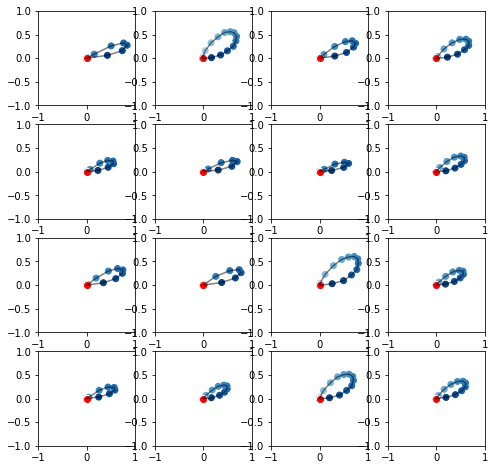

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 1.0593692898750304, Dr : 0.01737314499914646, Df : 0.01748919039964676


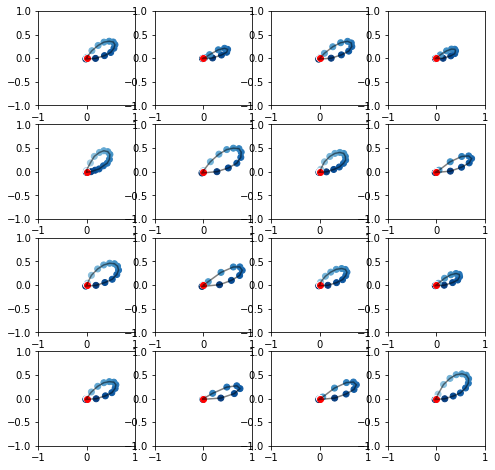

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 1.3575016975402832, Dr : 0.0031239027273841204, Df : 0.00681639201939106


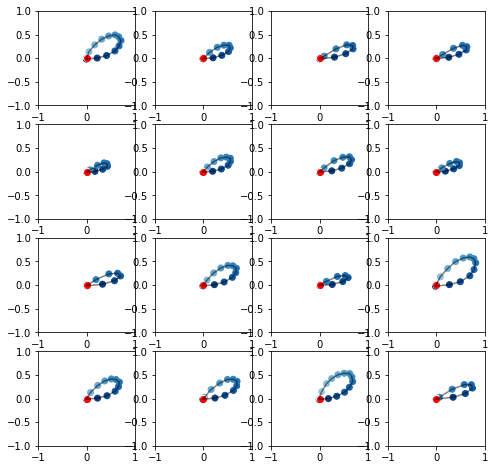

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 1.618716549873352, Dr : 0.0033413687371648846, Df : 0.0010503935744054615


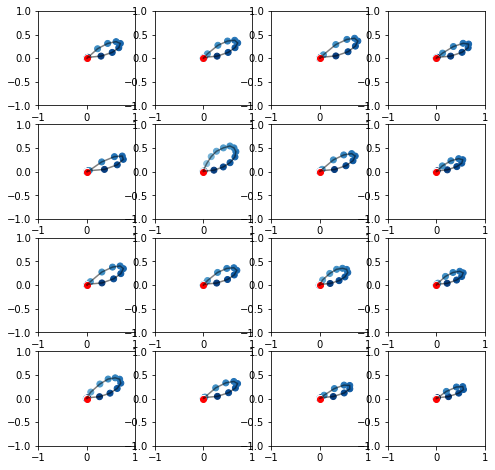

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 1.6294689416885375, Dr : 0.00340567542007193, Df : 0.0025731589179486037


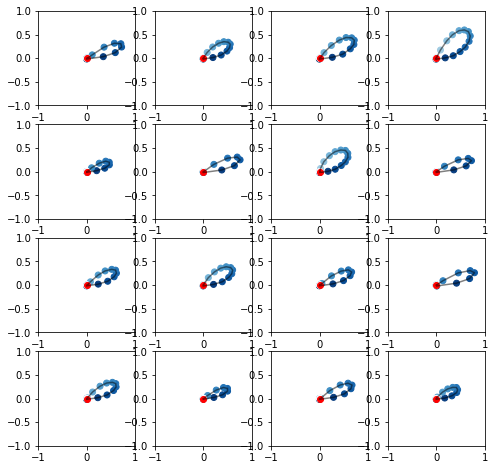

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.7737709760665894, Dr : 0.10020436896011234, Df : 0.06921287444420159


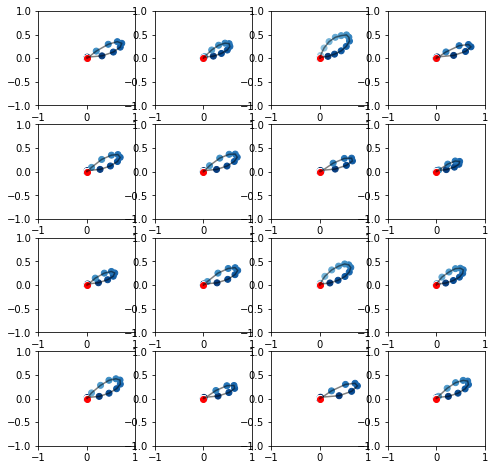

In [25]:
generator = CNNGenerator()
discriminator = CNNDiscriminator()

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_cnn.train(nb_epoch, lr, device)

# LSTM - LSTM


Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.18260231912136077, Dr : 0.18015624582767487, Df : 0.16429561674594878


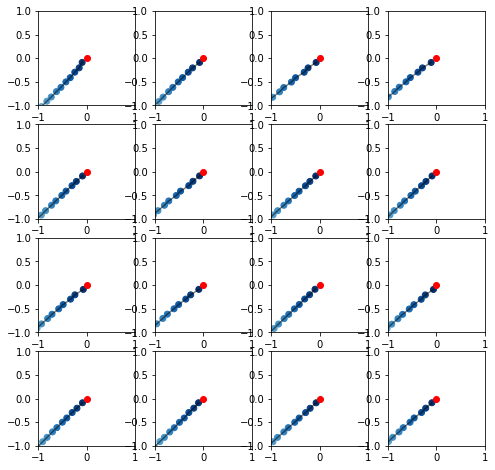

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.19791896939277648, Dr : 0.15975692570209504, Df : 0.16429852247238158


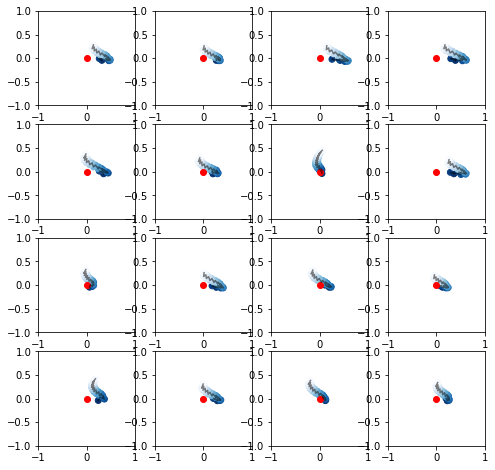

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.23630184531211854, Dr : 0.11604618430137634, Df : 0.13787363469600677


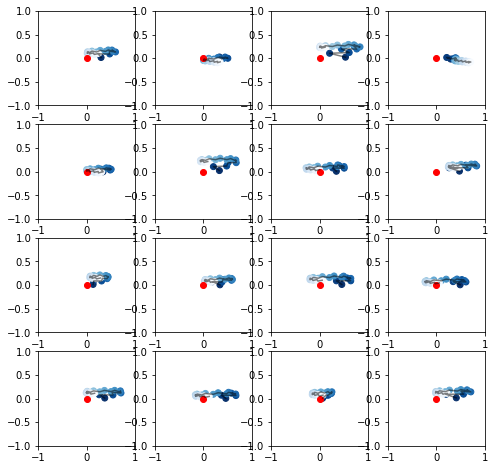

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.25055440664291384, Dr : 0.10891826152801513, Df : 0.116379876434803


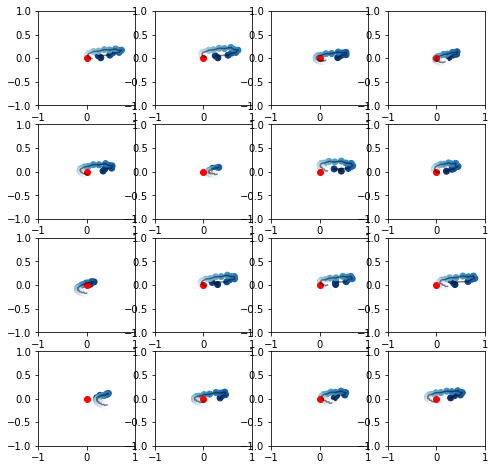

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.2580875426530838, Dr : 0.10477318912744522, Df : 0.1074074700474739


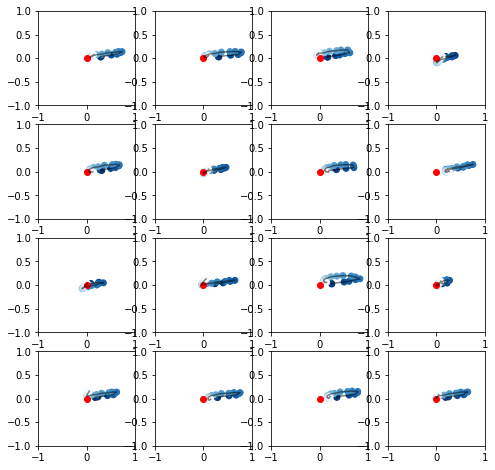

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.2632794439792633, Dr : 0.0995118111371994, Df : 0.111274853348732


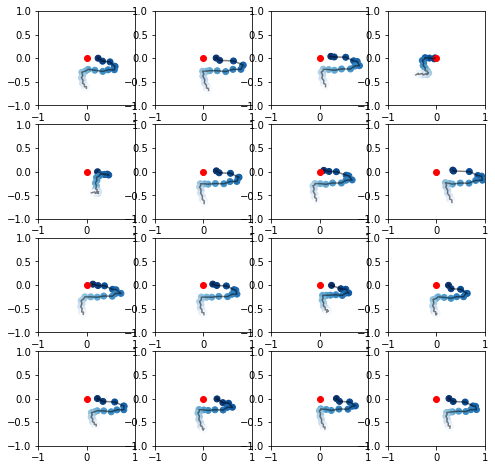

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.27605541944503786, Dr : 0.10572229623794556, Df : 0.10412726849317551


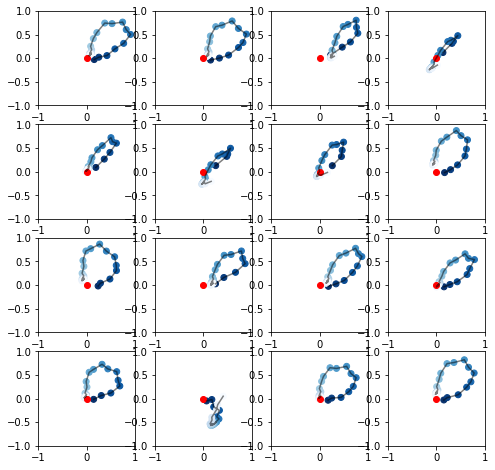

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.29008609652519224, Dr : 0.10832617729902268, Df : 0.09747536778450012


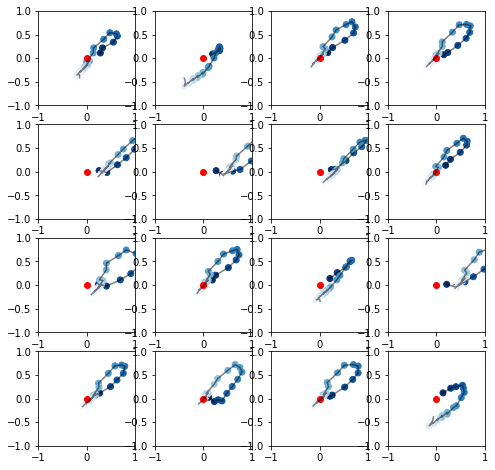

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.2792341589927673, Dr : 0.10123633891344071, Df : 0.09708938300609589


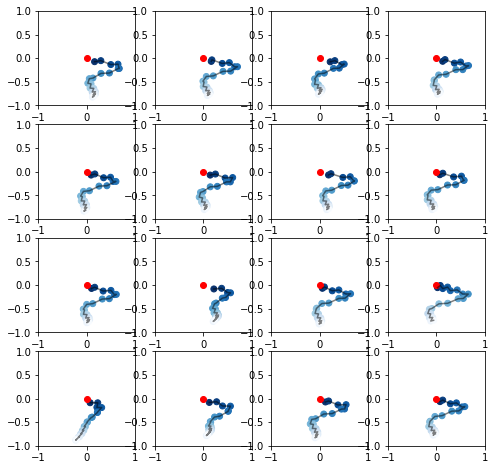

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.29103417992591857, Dr : 0.10288596004247666, Df : 0.09560177773237229


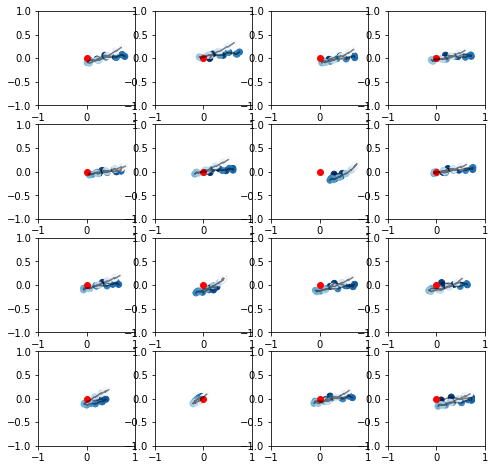

In [26]:
generator = LSTMGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

# ### WEIGHT INITIALIZATION
# generator.apply(weights_init)
# discriminator.apply(weights_init)

lstm_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_lstm.train(nb_epoch, lr, device)

# LSTM - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.1924057722091675, Dr : 0.14432462751865388, Df : 0.16006089746952057


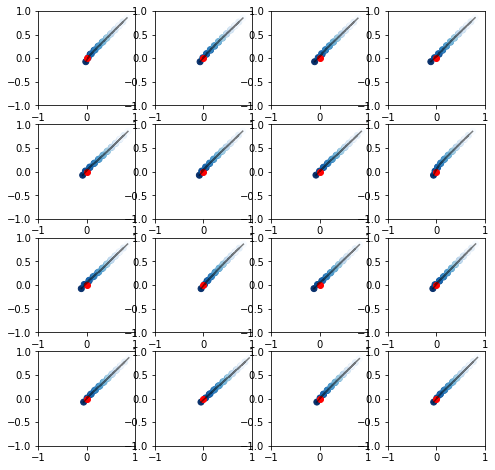

Epoch [501/5000] -----------------------------------------------------------------------------
G: 1.6832011461257934, Dr : 0.00023387505789287388, Df : 0.00034120597410947084


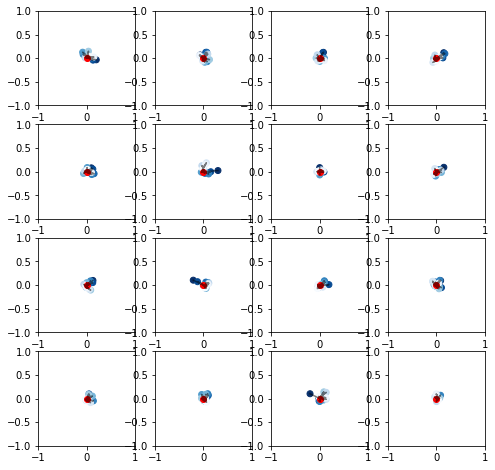

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 2.155312967300415, Dr : 3.7299142422853035e-05, Df : 5.0434627337381246e-05


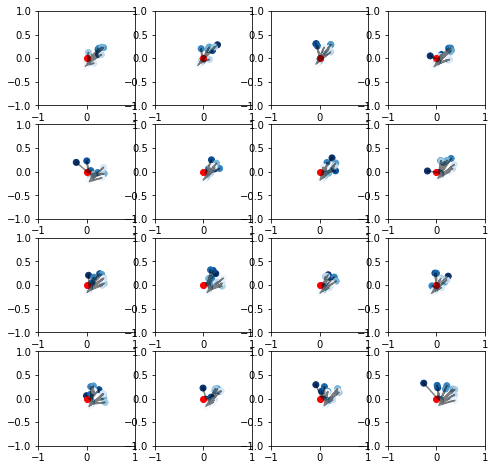

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 1.8095259428024293, Dr : 0.0002678085205843672, Df : 0.0007349917199462652


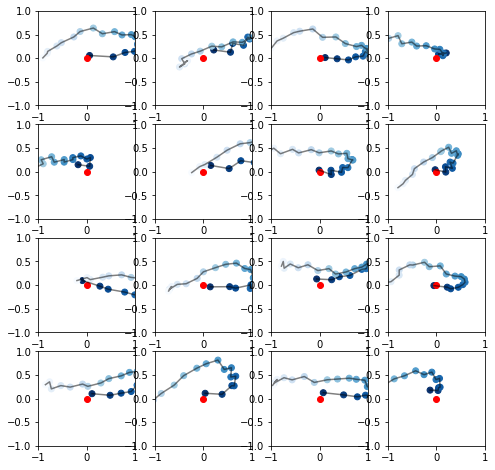

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 2.6220638275146486, Dr : 9.546434102958302e-06, Df : 1.0985985318257007e-05


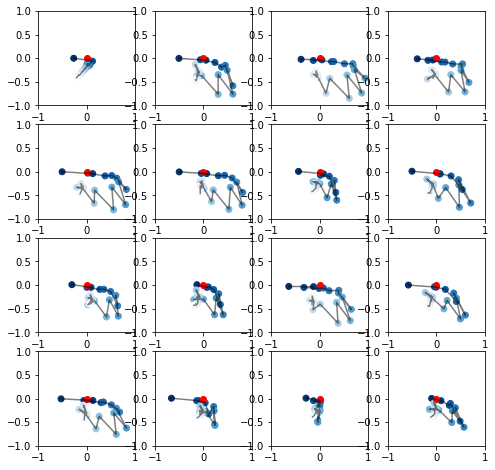

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 2.9922063827514647, Dr : 5.328496126821847e-06, Df : 8.624892348052527e-06


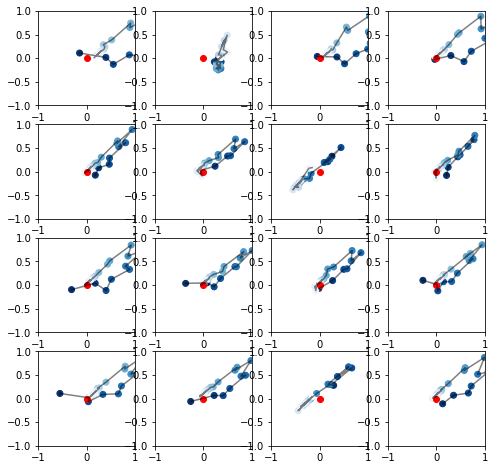

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 1.884335446357727, Dr : 0.0010280341492034494, Df : 0.001233735663117841


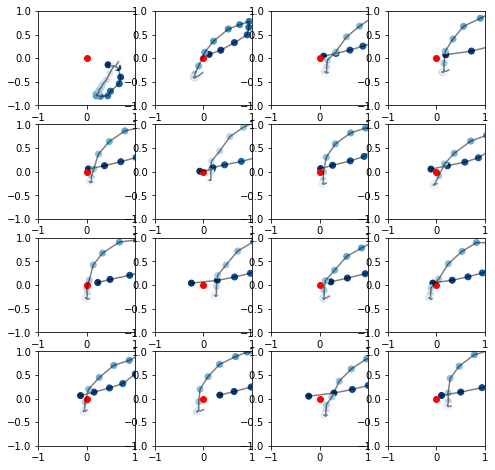

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 2.6634231090545653, Dr : 1.4271321379055735e-05, Df : 2.771128056338057e-05


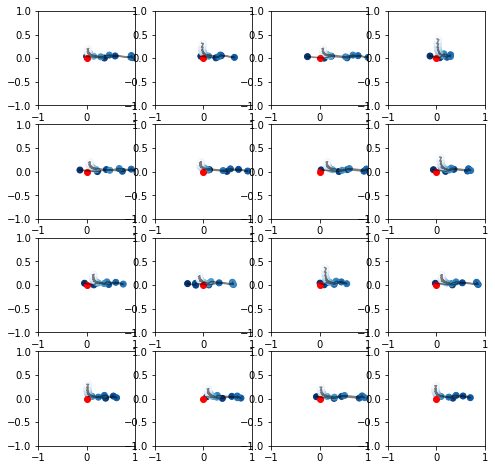

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 3.0233070850372314, Dr : 3.480696159385843e-06, Df : 5.342722306522773e-06


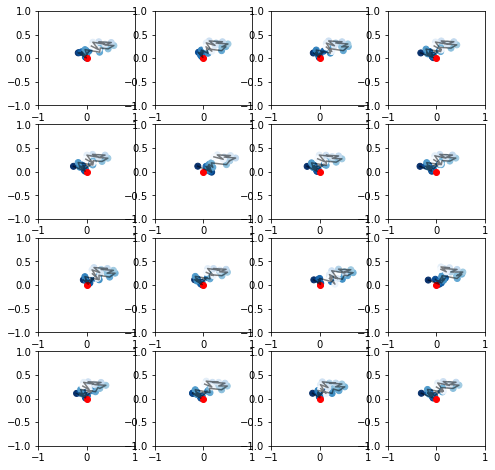

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 3.139215326309204, Dr : 1.267800382720452e-06, Df : 2.61450809375674e-06


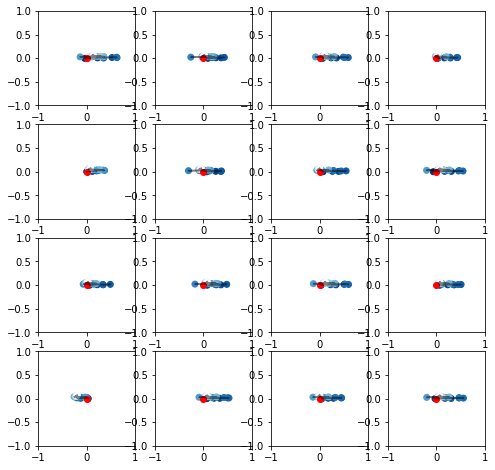

In [27]:
generator = LSTMGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

lstm_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_cnn.train(nb_epoch, lr, device)

# CNN - LSTM

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.20362990498542785, Dr : 0.2044476717710495, Df : 0.14613416492938996


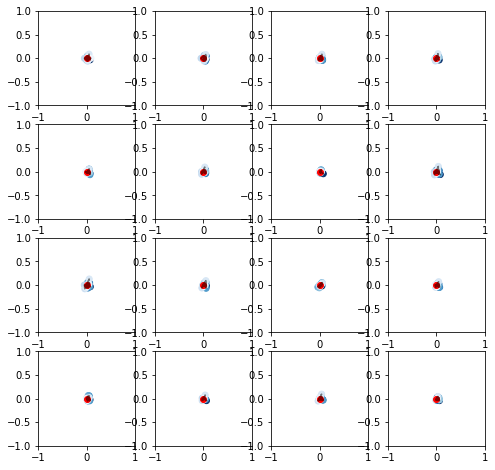

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.1731196314096451, Dr : 0.173137429356575, Df : 0.17328990995883942


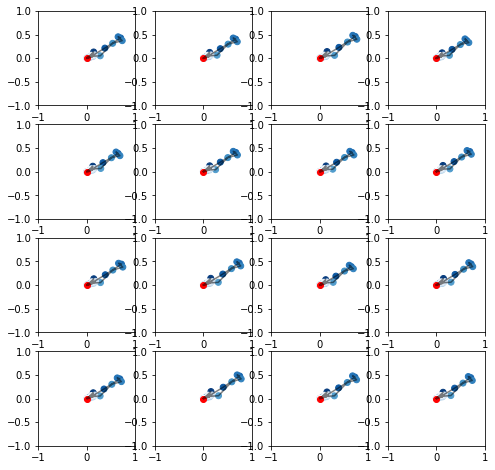

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.17333535254001617, Dr : 0.1732437640428543, Df : 0.17337398529052733


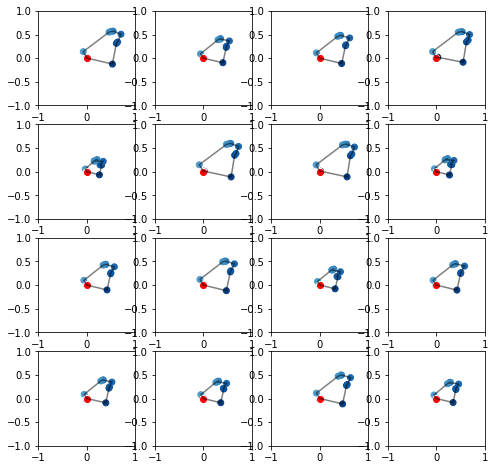

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.17330384254455566, Dr : 0.17327366173267364, Df : 0.1733025074005127


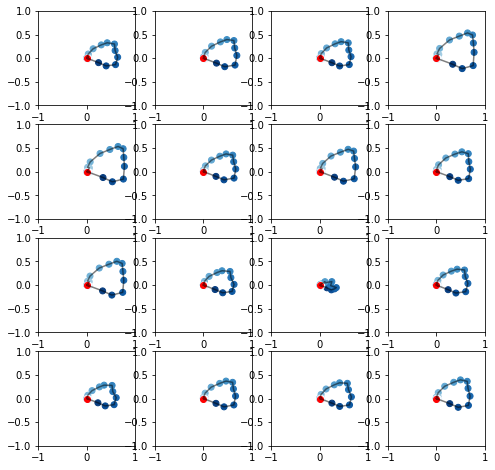

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.17328954339027405, Dr : 0.17336175441741944, Df : 0.1732591211795807


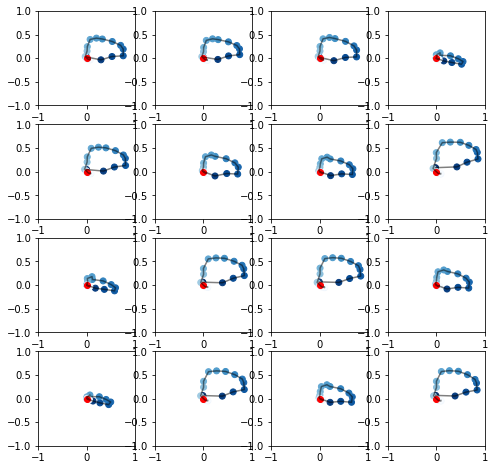

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.1732833206653595, Dr : 0.17334149777889252, Df : 0.17324574291706085


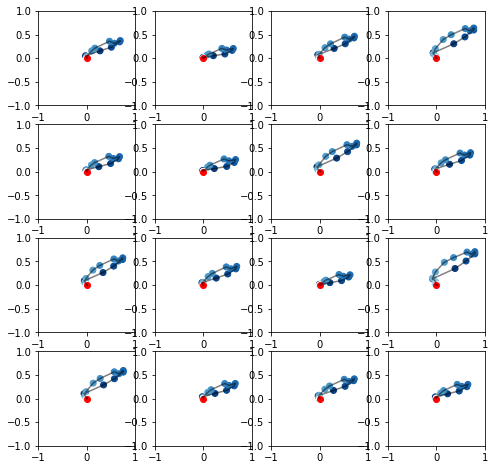

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.1732862710952759, Dr : 0.17310627698898315, Df : 0.17328374683856965


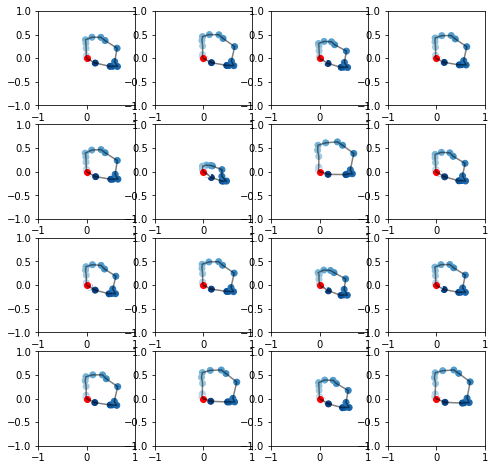

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.17334830462932588, Dr : 0.17332897782325746, Df : 0.17326468825340272


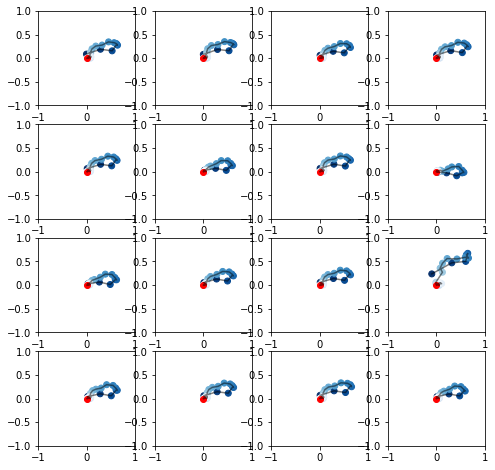

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.17331947684288024, Dr : 0.17328107059001924, Df : 0.17323897182941436


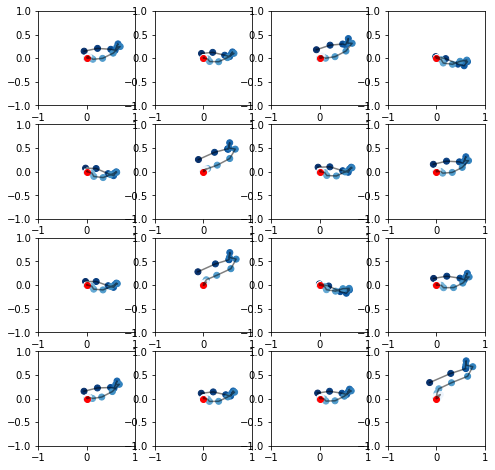

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.1732209324836731, Dr : 0.17325146794319152, Df : 0.17335131764411926


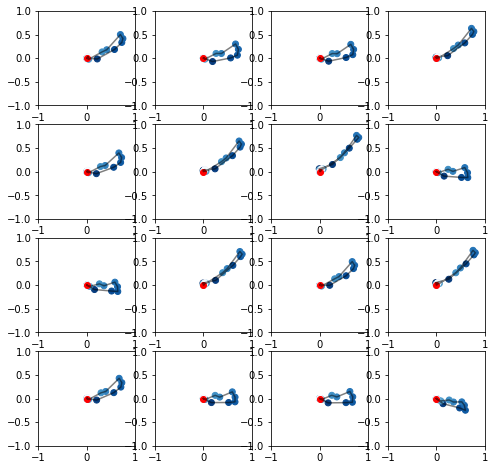

In [28]:
generator = CNNGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_lstm.train(nb_epoch, lr, device)

# RESULTS

Text(0, 0.5, 'Score')

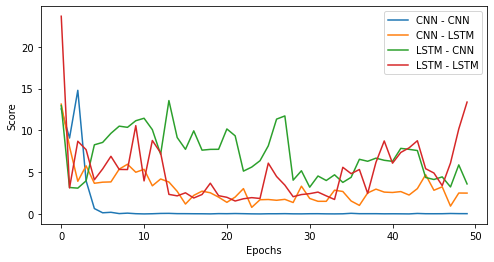

In [83]:
plt.figure(figsize=(8,4))
plt.plot(cnn_cnn.score, label = "CNN - CNN")
plt.plot(cnn_lstm.score, label = "CNN - LSTM")
plt.plot(lstm_cnn.score, label = "LSTM - CNN")
plt.plot(lstm_lstm.score, label = "LSTM - LSTM")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')

<BarContainer object of 4 artists>

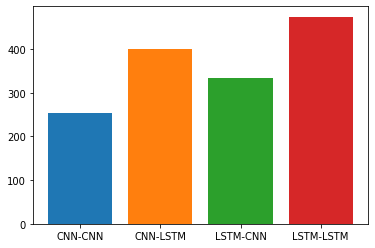

In [53]:
plt.bar(x = ['CNN-CNN', 'CNN-LSTM', 'LSTM-CNN', 'LSTM-LSTM'], 
        height = [cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time],
        color = [dicolour['blue'], dicolour['orange'], dicolour['green'], dicolour['red']])

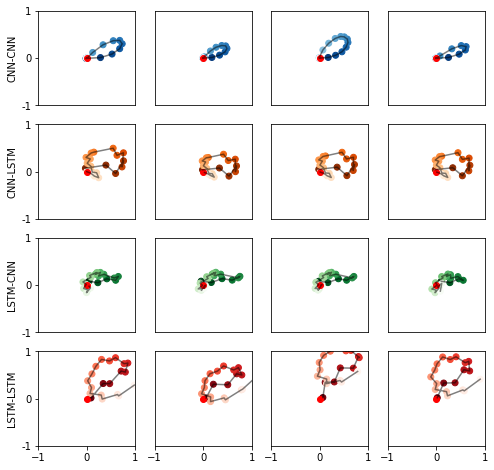

In [79]:
plt.figure(figsize=(8,8))

nb = 4
traj_sim = cnn_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)


nb = 4
traj_sim = cnn_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+4)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-LSTM')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+8)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+12)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Reds_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-LSTM')
  ax = plt.gca()
  if i >0:
    ax.axes.yaxis.set_visible(False)

In [84]:
cnn_cnn.save('cnn_cnn_20_steps_flower')
lstm_cnn.save('lstm_cnn_20_stepss_flower')
cnn_lstm.save('cnn_lstm_20_stepss_flower')
lstm_lstm.save('lstm_lstm_20_stepss_flower')